In [0]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import warnings
from statistics import median

import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2020/01/ipl_batting_partnerships.csv")
df.head()

,index,team,player_1,player_2,score_1,score_2
0,0,Chennai Super Kings,AT Rayudu,SR Watson,7,0
1,1,Chennai Super Kings,AT Rayudu,SK Raina,12,19
2,2,Chennai Super Kings,AT Rayudu,KM Jadhav,9,9
3,3,Chennai Super Kings,RA Jadeja,KM Jadhav,6,4
4,19,Sunrisers Hyderabad,DA Warner,JM Bairstow,74,39


# Data Preparation

In [3]:
# prepare dataframe for Delhi Capitals
df_dc = df[df['team']=="Delhi Capitals"]

df_dc['partners'] = [sorted([i,j]) for i,j in zip(df_dc['player_1'], df_dc['player_2'])]
df_dc['partnership'] = ["".join(i) for i in df_dc['partners']]

df_dc.head()

,index,team,player_1,player_2,score_1,score_2,partners,partnership
17,32,Delhi Capitals,S Dhawan,PP Shaw,2,7,"[PP Shaw, S Dhawan]",PP ShawS Dhawan
18,33,Delhi Capitals,S Dhawan,SS Iyer,2,16,"[S Dhawan, SS Iyer]",S DhawanSS Iyer
19,34,Delhi Capitals,S Dhawan,CA Ingram,36,47,"[CA Ingram, S Dhawan]",CA IngramS Dhawan
20,35,Delhi Capitals,S Dhawan,RR Pant,3,16,"[RR Pant, S Dhawan]",RR PantS Dhawan
21,36,Delhi Capitals,KMA Paul,RR Pant,3,21,"[KMA Paul, RR Pant]",KMA PaulRR Pant


In [0]:
# empty list to store players name
p1 = []
p2 = []

# empty lists to store median of runs scored
r1 = []
r2 = []

for p in df_dc['partnership'].unique():
    
    temp = df_dc[df_dc['partnership'] == p]
    p1.append(temp.iloc[0]['player_1'])
    p2.append(temp.iloc[0]['player_2'])
    
    a = []
    b = []
    
    # extract individual scores for both the players
    for index, row in temp.iterrows():
        # scores of player 1
        a.append(row['score_1'])
        
        # scores of player 2
        b.append(row['score_2'])

    # append median of scores    
    r1.append(median(a))
    r2.append(median(b))

In [5]:
# aggregated batting-partnership data
team_df = pd.DataFrame({'p1':p1, 'p2':p2, 'r1':r1, 'r2':r2})
team_df.head()

,p1,p2,r1,r2
0,S Dhawan,PP Shaw,13.0,11.0
1,S Dhawan,SS Iyer,21.5,23.0
2,S Dhawan,CA Ingram,4.0,14.0
3,S Dhawan,RR Pant,8.0,20.5
4,KMA Paul,RR Pant,3.0,13.0


In [0]:
# find the leading batsman
team_df['lead'] = np.where(team_df['r1'] >= team_df['r2'], team_df['p1'], team_df['p2'])
team_df['follower'] = np.where(team_df['lead'] == team_df['p1'], team_df['p2'], team_df['p1'])
team_df['larger_score'] = np.where(team_df['r1'] >= team_df['r2'], team_df['r1'], team_df['r2'])
team_df['total_score'] = team_df['r1'] + team_df['r2']

# performance ratio
team_df['performance'] = team_df['larger_score']/(team_df['total_score']+0.01)

# Construct Network

In [0]:
# construct graph
G = nx.from_pandas_edgelist(team_df, "follower", "lead", ['performance'], create_using=nx.MultiDiGraph())

# get edge weights
_, wt = zip(*nx.get_edge_attributes(G, 'performance').items())

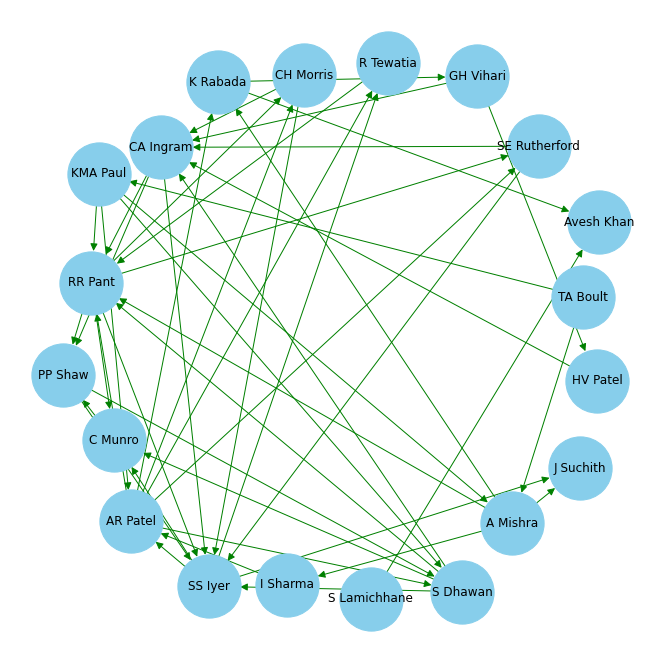

In [8]:
# plot graph
plt.figure(figsize=(9,9))
pos = nx.spring_layout(G, k = 20, seed = 21) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=4000, pos = pos, edgelist=G.edges(), edge_color='g', arrowsize=15)
plt.show()

In [9]:
list(G.degree)

[('PP Shaw', 5),
 ('S Dhawan', 7),
 ('SS Iyer', 10),
 ('CA Ingram', 8),
 ('RR Pant', 11),
 ('KMA Paul', 5),
 ('AR Patel', 9),
 ('R Tewatia', 3),
 ('GH Vihari', 3),
 ('HV Patel', 2),
 ('CH Morris', 4),
 ('K Rabada', 4),
 ('Avesh Khan', 2),
 ('S Lamichhane', 1),
 ('I Sharma', 2),
 ('C Munro', 4),
 ('A Mishra', 6),
 ('SE Rutherford', 4),
 ('J Suchith', 2),
 ('TA Boult', 2)]

In [10]:
list(G.in_degree)

[('PP Shaw', 3),
 ('S Dhawan', 3),
 ('SS Iyer', 6),
 ('CA Ingram', 5),
 ('RR Pant', 6),
 ('KMA Paul', 1),
 ('AR Patel', 3),
 ('R Tewatia', 2),
 ('GH Vihari', 1),
 ('HV Patel', 1),
 ('CH Morris', 2),
 ('K Rabada', 2),
 ('Avesh Khan', 2),
 ('S Lamichhane', 0),
 ('I Sharma', 1),
 ('C Munro', 3),
 ('A Mishra', 2),
 ('SE Rutherford', 2),
 ('J Suchith', 2),
 ('TA Boult', 0)]